In [1]:
import os
import io
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Example of data:  [('rubbertoy',)]
1.) Voxels
0.0 1.0 (32, 32, 32, 1)
plot


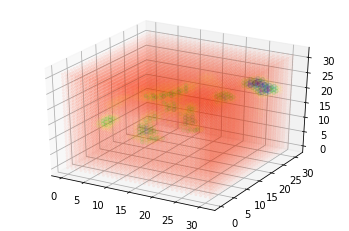

3.) plane
Min: -2.4222006797790527, Max: 1.5789142847061157, Shape: (128, 128, 1)


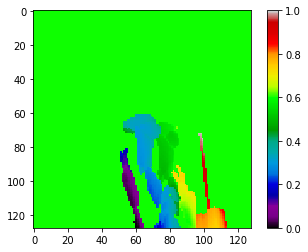

4.) cylinder
Min: 0.0, Max: 2.3236749172210693, Shape: (128, 128, 1)


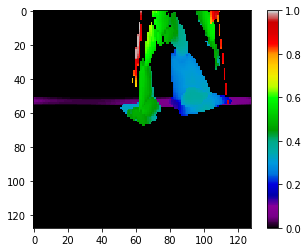

4.) sphere
Min: 0.0, Max: 4.0168328285217285, Shape: (128, 128, 1)


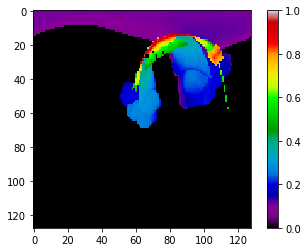

In [2]:
import sqlite3
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

# Utility functions: 
# Plot Voxels as a point cloud:
def plot_voxels(nvoxels, resolution=9, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()

    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels.max() - nvoxels[x, z, y, 0] ))
    ax.scatter(xs, ys, zs, s=sizes, c=sizes, alpha=alpha)
    
# Store Numpy array in SqLite database:
def adapt_array(arr):
    """
    Save Numpy array to SqLite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    """ 
    Load Numpy array from Sqlite.
    Source:
    http://stackoverflow.com/a/31312102/190597 (SoulNibbler)
    """
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

conn = sqlite3.connect("recognise_3d.db", isolation_level=None, detect_types=sqlite3.PARSE_DECLTYPES)
query = "SELECT orientation FROM data WHERE id = 33"
cursor = conn.cursor()
cursor.execute(query)
print("Example of data: ", cursor.fetchall())

query = "SELECT voxels, plane, cylinder, sphere FROM data WHERE id = 31"
cursor = conn.cursor()
cursor.execute(query)
sample = cursor.fetchall()
voxels, plane, cylinder, sphere = sample[0]
nvoxels = np.asarray(voxels).reshape((32, 32, 32, 1))
nvoxels -= nvoxels.min()
nvoxels /= nvoxels.max()
nvoxels = 1- nvoxels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

print("1.) Voxels")
print(nvoxels.min(), nvoxels.max(), nvoxels.shape)
def plot_voxels(nvoxels, resolution=32, point_size=10, alpha=1):
    xs = list()
    ys = list()
    zs = list()
    sizes = list()
    colors = list()
    cmap = plt.cm.get_cmap('nipy_spectral')
    
    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                xs.append(x)
                ys.append(y)
                zs.append(z)
                sizes.append(point_size*(nvoxels.max() - nvoxels[x, z, y, 0] ))
                c = cmap(nvoxels[x, z, y, 0])
                colors.append((c[0], c[1], c[2], (alpha*(1-nvoxels[x, z, y, 0]))))
    print("plot")
    ax.scatter(xs, ys, zs, s=sizes, c=colors)
plot_voxels(nvoxels, resolution=32, point_size=30, alpha=0.4)
plt.show()

print("3.) plane")
print("Min: {}, Max: {}, Shape: {}".format(plane.min(), plane.max(), plane.shape))
plane = plane.reshape(128, 128)
plane -= plane.min()
plane /= plane.max()
plt.imshow(plane,cmap='nipy_spectral')
plt.colorbar()
plt.show()
print("4.) cylinder")
print("Min: {}, Max: {}, Shape: {}".format(cylinder.min(), cylinder.max(), cylinder.shape))
cylinder = cylinder.reshape(128, 128)
cylinder -= cylinder.min()
cylinder /= cylinder.max()
plt.imshow(cylinder,cmap='nipy_spectral')
plt.colorbar()
plt.show()
print("4.) sphere")
print("Min: {}, Max: {}, Shape: {}".format(sphere.min(), sphere.max(), sphere.shape))
sphere = sphere.reshape(128, 128)
sphere -= sphere.min()
sphere /= sphere.max()
plt.imshow(sphere,cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [3]:
import keras
import io
import math

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.utils import to_categorical
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [29]:
from sklearn.preprocessing import OneHotEncoder

CATEGORIES = ["tommy", "squab", "rubbertoy", "pighead", "crag"]
CATEGORIES_ONE_HOT = {i: [x==i for x in CATEGORIES] for i in CATEGORIES}

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras from SQLite database'
    def __init__(self, path, num_features, end_index=None, start_index=1, batch_size=25,
                 shuffle=True, dim=(9, 9, 9), column="voxels"):
        'Initialization'
        sqlite3.register_adapter(np.ndarray, adapt_array)
        sqlite3.register_converter("array", convert_array)
        self.path = path
        self.dim = dim
        self.db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES, check_same_thread=False)
        self.db_cursor = self.db.cursor()
        self.N = num_features
        self.start_index = start_index
        if end_index is None:
            end_index =  num_features + start_index
        self.end_index = end_index
        self.column = column
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.sample_index = np.arange(self.start_index, self.end_index)
        self.on_epoch_end()
        self.db.close()


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.N / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data - generates indexes of the batch'
        # Generate indexes of the batch
        samples_batch = np.arange((index) * self.batch_size, (index+1) * self.batch_size)

        # Generate data
        x, y = self.__data_generation(samples_batch)

        return  x, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.sample_index)

    def __data_generation(self, samples_batch):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x = np.empty((self.batch_size, *self.dim))
        y = np.empty(shape=(self.batch_size, 5))
        inds = self.sample_index[samples_batch]
        sqlite3.register_adapter(np.ndarray, self.adapt_array)
        sqlite3.register_converter("array", self.convert_array)
        db = sqlite3.connect(self.path, detect_types=sqlite3.PARSE_DECLTYPES)
        db_cursor = db.cursor()
        sql_query = "SELECT orientation, {column} FROM data WHERE id in ({index})".\
            format(column=self.column, index=','.join(str(ind) for ind in inds))
        db_cursor.execute(sql_query)
        for i in range(self.batch_size):
            line = db_cursor.fetchone()
            y[i] = CATEGORIES_ONE_HOT[line[0]]
            x_tmp = line[1].reshape(self.dim)
            x_tmp -= x_tmp.min()
            x_tmp /= x_tmp.max()
            x[i, :] = x_tmp
        return x, y

1.) Voxels - the same CNN

In [30]:
voxel_training_generator = DataGenerator("/home/pawel/git/recognise_3d.db", num_features=4500, dim=(32, 32, 32, 1), batch_size=32, column="voxels")
voxel_validation_generator = DataGenerator("/home/pawel/git/recognise_3d.db", num_features=500, start_index=4500, dim=(32, 32, 32, 1), batch_size=32, column="voxels")

15
[0. 0. 0. 0. 1.] crag
plot


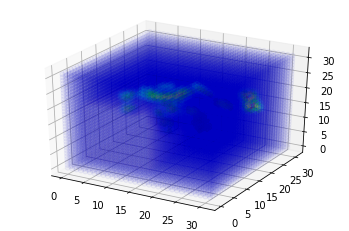

In [31]:
print(len(voxel_validation_generator))
y = voxel_validation_generator[1][1][0]
cat_name = CATEGORIES[np.where(y==1)[0][0]]
print(y, cat_name)
v = voxel_validation_generator[1][0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_voxels(v, resolution=32, point_size=30, alpha=0.4)

In [32]:
#General callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.001)

In [33]:
# Callbacks for dense
checkpoint_dense_voxel = keras.callbacks.ModelCheckpoint(filepath='/tmp/weights_dense_voxel_rec.hdf5', verbose=0, save_best_only=True)
store_result_dense_voxel = keras.callbacks.callbacks.CSVLogger("results_dense_voxel_rec.csv", separator=',', append=False)

In [23]:
# Build convolutional neural net

model_cnn_voxels = Sequential()

model_cnn_voxels.add(Conv3D(16,(5,5,5), padding = 'same', activation = 'relu', input_shape = (32,32,32,1)))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Conv3D(32, (5,5,5), padding = 'same', activation = 'relu'))
model_cnn_voxels.add(BatchNormalization())
model_cnn_voxels.add(MaxPooling3D(pool_size = (2,2,2)))
model_cnn_voxels.add(Dropout(0.1))

model_cnn_voxels.add(Flatten())
model_cnn_voxels.add(Dense(128, activation = 'relu'))
model_cnn_voxels.add(Dense(5, activation="tanh"))

model_cnn_voxels.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])
model_cnn_voxels.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 32, 32, 32, 16)    2016      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32, 16)    64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 16, 16, 16, 16)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 16, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 16, 16, 16, 32)    64032     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 16, 32)    128       
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 8, 8, 32)      

In [51]:
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_cnn_voxels = model_cnn_voxels.fit_generator(voxel_training_generator, verbose=1, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                    callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_cnn_voxels.save('dense_voxel_rec.model')

Epoch 1/500
140/140 [==============================] - 145s 1s/step - loss: 4.8246 - accuracy: 0.3571 - val_loss: 5.0369 - val_accuracy: 0.3625

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/500
140/140 [==============================] - 145s 1s/step - loss: 4.8786 - accuracy: 0.3592 - val_loss: 8.5627 - val_accuracy: 0.3646

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/500
140/140 [==============================] - 145s 1s/step - loss: 4.8606 - accuracy: 0.3551 - val_loss: 5.0369 - val_accuracy: 0.3729

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/500
140/140 [==============================] - 146s 1s/step - loss: 4.8606 - accuracy: 0.3565 - val_loss: 5.0369 - val_accuracy: 0.3646

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/500
140/140 [==============================] - 145s 1s/step - loss: 4.8606 - accuracy: 0.3578 - val_loss: 4.0295 - val_accuracy: 0.3646

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/500
140/140 

KeyboardInterrupt: 

VoxNet

In [48]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv3D, MaxPooling3D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from types import MappingProxyType


class ModelVoxNet(object):

    def __init__(self, number_class,
                 parameter_dict={
                     'input_shape': (32, 32, 32, 1),
                     'filter_size': 32,
                     'conv_kernel_size_1': 5,
                     'conv_kernel_size_2': 3,
                     'strides_1': (2, 2, 2),
                     'strides_2': (1, 1, 1),
                     'drop_out_rate_list': [0.3, 0.4, 0.5],
                     'pool_size': (2, 2, 2),
                     'units': 128
                 }
                 ):
        # init model

        default_parameter_dict = parameter_dict
        default_parameter_dict = MappingProxyType(default_parameter_dict)
        self.default_parameter_dict = default_parameter_dict

        count_dict = {}

        with tf.name_scope('Model'):
            with tf.name_scope('Inputs'):
                inputs = Input(default_parameter_dict['input_shape'])

            # convolution 1

            count_dict['Conv3D'] = 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_1'],
                           padding='valid',
                           strides=default_parameter_dict['strides_1'],
                           data_format='channels_last',
                           )(inputs)

            # Activation Leaky ReLu

            count_dict['Activation_relu'] = 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # dropout 1

            count_dict['Dropout'] = 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][0])(x)

            # convolution 2

            count_dict['Conv3D'] += 1

            with tf.name_scope('Conv3D_' + str(count_dict['Conv3D'])):
                x = Conv3D(filters=default_parameter_dict['filter_size'],
                           kernel_size=default_parameter_dict[
                               'conv_kernel_size_2'],
                           padding='valid',
                           strides=default_parameter_dict['strides_2'],
                           data_format='channels_last',
                           )(x)

            # Activation Leaky ReLu
            count_dict['Activation_relu'] += 1

            with tf.name_scope(
                    'Activation_relu_' + str(count_dict['Activation_relu'])):
                x = Activation('relu')(x)

            # max pool 1
            with tf.name_scope('MaxPooling3D'):
                x = MaxPooling3D(pool_size=default_parameter_dict['pool_size'],
                                 strides=None,
                                 padding='valid',
                                 data_format='channels_last',
                                 )(x)

            # dropout 2
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 1 (fully connected layer)

            with tf.name_scope('Flatten'):
                x = Flatten()(x)

            count_dict['Dense'] = 1

            with tf.name_scope('Dense'):
                x = Dense(units=default_parameter_dict['units'],
                          activation='linear', )(x)

            # dropout 3
            count_dict['Dropout'] += 1

            with tf.name_scope('Dropout_' + str(count_dict['Dropout'])):
                x = Dropout(
                    rate=default_parameter_dict['drop_out_rate_list'][2])(x)

            # dense 2 (fully connected layer)

            count_dict['Dense'] += 1

            with tf.name_scope('Dense'):
                x = Dense(units=number_class,
                          activation='linear',
                          )(x)

            # Activation Softmax
            with tf.name_scope('Activation_softmax'):
                outputs = Activation("softmax")(x)

            self.model = Model(inputs=[inputs], outputs=[outputs])
            self.model.summary()
model_vox_net = ModelVoxNet(5).model
model_vox_net.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=["accuracy"])
# https://github.com/SnowMasaya/Generative-and-Discriminative-Voxel-Modeling-Keras/tree/master/src

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 32, 1)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 14, 32)    0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 14, 32)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
activation_8 (Activation)    (None, 12, 12, 12, 32)    0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 6, 6, 6, 32)       0   

In [50]:
# Using workers=2, use_multiprocessing=True sometimes resulted in freeze
result_cnn_voxel_net = model_vox_net.fit_generator(voxel_training_generator, verbose=1, validation_data=voxel_validation_generator,
                                                     epochs=500, 
                                                     callbacks=[early_stopping, checkpoint_dense_voxel, store_result_dense_voxel, reduce_lr])
model_vox_net.save('dense_voxel_trained_model_rec.model')

Epoch 1/500
140/140 [==============================] - 32s 230ms/step - loss: 0.5778 - accuracy: 0.7578 - val_loss: 0.3299 - val_accuracy: 0.9021

Epoch 00001: val_loss improved from inf to 0.32995, saving model to /tmp/weights_dense_voxel_rec.hdf5
Epoch 2/500
140/140 [==============================] - 31s 220ms/step - loss: 0.2711 - accuracy: 0.9018 - val_loss: 0.1252 - val_accuracy: 0.9667

Epoch 00002: val_loss improved from 0.32995 to 0.12517, saving model to /tmp/weights_dense_voxel_rec.hdf5
Epoch 3/500
140/140 [==============================] - 30s 214ms/step - loss: 0.1706 - accuracy: 0.9415 - val_loss: 0.0353 - val_accuracy: 0.9771

Epoch 00003: val_loss improved from 0.12517 to 0.03528, saving model to /tmp/weights_dense_voxel_rec.hdf5
Epoch 4/500
140/140 [==============================] - 29s 208ms/step - loss: 0.1390 - accuracy: 0.9502 - val_loss: 0.1867 - val_accuracy: 0.9792

Epoch 00004: val_loss did not improve from 0.03528
Epoch 5/500
140/140 [==========================

140/140 [==============================] - 35s 249ms/step - loss: 0.0112 - accuracy: 0.9960 - val_loss: 5.4386e-04 - val_accuracy: 0.9854

Epoch 00079: val_loss did not improve from 0.00000
Epoch 80/500
140/140 [==============================] - 34s 243ms/step - loss: 0.0241 - accuracy: 0.9942 - val_loss: 1.3558e-05 - val_accuracy: 0.9875

Epoch 00080: val_loss did not improve from 0.00000
Epoch 81/500
140/140 [==============================] - 34s 246ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 3.1143e-06 - val_accuracy: 0.9896

Epoch 00081: val_loss did not improve from 0.00000
Epoch 82/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0344 - accuracy: 0.9931 - val_loss: 5.3158e-06 - val_accuracy: 0.9917

Epoch 00082: val_loss did not improve from 0.00000
Epoch 83/500
140/140 [==============================] - 34s 242ms/step - loss: 0.0311 - accuracy: 0.9926 - val_loss: 0.0636 - val_accuracy: 0.9896

Epoch 00083: val_loss did not improve from 0.00000
Ep